In [1]:
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
from scipy import io
import warnings
import os
import h5py
from tqdm import tqdm_notebook as tqdm
old_v = tf.logging.get_verbosity()
if os.path.exists("../logs/Depth"):
    shutil.rmtree("../logs/Depth")
tf.logging.set_verbosity(tf.logging.ERROR)

# ハイパーパラメータ

In [2]:
X_n = (120, 160) # (h, w)
enc_n = [64, 128, 256]
kernel = (3, 3)


# 入力データ

In [3]:
f = h5py.File("nyu_depth_v2_labeled.mat", "r")

In [4]:
images, depth_images = [], []
for i,_ in tqdm(enumerate(f["images"])):
    gray = cv2.cvtColor(f["images"][i].T, cv2.COLOR_BGR2GRAY)
    expand = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
    resize = cv2.resize(expand, (160, 120))
    reshape = np.reshape(resize, [120, 160, 1])
    images.append(reshape)
    
    gray = f["depths"][i].T
    expand = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
    resize = cv2.resize(expand, (160, 120))
    depth_images.append(resize)
images = np.array(images)
depth_images = np.array(depth_images)
    
train_X, test_X = images[:1000], images[1000:]
train_Y, test_Y = depth_images[:1000], depth_images[1000:]

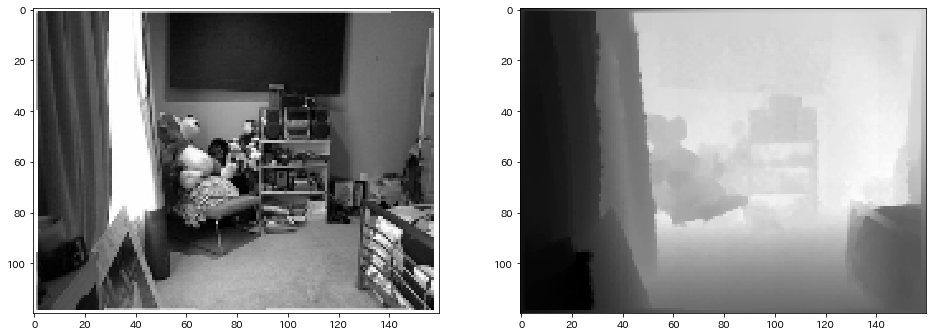

In [5]:
num = 0
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.imshow(test_X[num,:,:,0], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(test_Y[num], cmap="gray")

# モデルアーキテクチャ

In [6]:
# X
with tf.name_scope("X"):
    X = tf.placeholder(tf.float32, [None, X_n[0], X_n[1], 1])
    
    print(X.shape)
    
# Y
with tf.name_scope("Y"):
    Y = tf.placeholder(tf.float32, [None, X_n[0], X_n[1]])
    
with tf.name_scope("U-Net"):
    m = 3
    stride, pooling = [1, 1, 1, 1], [1, 2, 2, 1]
    enc_w, enc_b, enc_h, enc_p = [],[], [], []
    for i, n in enumerate(enc_n):
        with tf.name_scope(f"enc{i + 1:02}"):
            w_shape = [kernel[0], kernel[1], 1 if i == 0 else m, n]
            enc_w.append(tf.Variable(tf.truncated_normal(w_shape, stddev=0.1)))
            enc_b.append(tf.Variable(tf.truncated_normal([n], stddev=0.1)))
            enc_h.append(tf.nn.relu(tf.nn.conv2d(X if i == 0 else enc_p[i - 1], enc_w[i], strides=stride, padding='SAME') + enc_b[i]))
            enc_p.append(tf.nn.max_pool(enc_h[i], ksize=pooling, strides=pooling, padding='SAME'))
            m = n

            print(enc_p[i].shape)
        
    m = enc_n[-1]
    dec_o, dec_w, dec_b, dec_h, dec_c = [], [], [], [], []
    dec_s, dec_a, dec_i, dec_p = [], [], [], []
    for i, n in enumerate(reversed(enc_n[:-1])):
        with tf.name_scope(f"dec{i + 1:02}"):
            w_shape = [kernel[0], kernel[1], n, m]
            s_shape = [kernel[0], kernel[1], m, n]
            o_shape = tf.stack([tf.shape(X)[0], X_n[0] // (2 ** (len(enc_n) - i - 1)), X_n[1] // (2 ** (len(enc_n) - i - 1)), n])
            dec_w.append(tf.Variable(tf.truncated_normal(w_shape, stddev=0.1)))
            dec_b.append(tf.Variable(tf.truncated_normal([n])))
            dec_h.append(tf.nn.relu(tf.nn.conv2d_transpose(enc_p[-1] if i == 0 else dec_p[i - 1], dec_w[i], o_shape, strides=pooling, padding='SAME') + dec_b[i]))
            dec_c.append(tf.concat([enc_p[-i - 2], dec_h[i]], 3))
            dec_s.append(tf.Variable(tf.truncated_normal(s_shape, stddev=0.1)))
            dec_a.append(tf.Variable(tf.truncated_normal([n], stddev=0.1)))
            dec_i.append(tf.nn.relu(tf.nn.conv2d(dec_c[i], dec_s[i], strides=stride, padding='SAME') + dec_a[i]))
            dec_p.append(tf.nn.max_pool(dec_i[i], ksize=pooling, strides=stride, padding='SAME'))
            m = n

            print(dec_p[i].shape)
    
    with tf.name_scope("G"):
        w_shape = [kernel[0], kernel[1], 1, enc_n[0]]
        Z_o = tf.stack([tf.shape(X)[0], X_n[0], X_n[1], 1])
        Z_w = tf.Variable(tf.truncated_normal(w_shape, stddev=0.1))
        Z_b = tf.Variable(tf.truncated_normal([1], stddev=0.1))
        Z = tf.nn.relu(tf.nn.conv2d_transpose(dec_p[-1], Z_w, Z_o, strides=pooling, padding='SAME') + Z_b)
        w_shape = [kernel[0], kernel[1], 1, 1]
        G_w = tf.Variable(tf.truncated_normal(w_shape, stddev=0.1))
        G_b = tf.Variable(tf.truncated_normal([1], stddev=0.1))
        G = tf.sigmoid(tf.nn.conv2d(Z, G_w, strides=stride, padding='SAME') + G_b)
        
        print(G.shape)
# loss
with tf.name_scope("loss"):
    loss = tf.nn.l2_loss(G[:, :, :, 0] - Y)

# Optimizer
with tf.name_scope("opt"):
    opt = tf.train.AdamOptimizer(1e-6).minimize(loss)


(?, 120, 160, 1)
(?, 60, 80, 64)
(?, 30, 40, 128)
(?, 15, 20, 256)
(?, 30, 40, 128)
(?, 60, 80, 64)
(?, 120, 160, 1)


### セッション開始

In [7]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
writer = tf.summary.FileWriter('../logs/Depth', sess.graph)

# トレーニング

In [ ]:
batch_size = 20
iteration_n = len(train_X) // batch_size
for epoch in range(500):
    epoch_loss = []
    for iteration in range(iteration_n - 1):
        batch_x = train_X[batch_size * iteration:batch_size * (iteration + 1)]
        batch_y = train_Y[batch_size * iteration:batch_size * (iteration + 1)]
        sess.run(opt, feed_dict={X: batch_x, Y: batch_y})
        step_loss = sess.run(loss, feed_dict={X: batch_x, Y: batch_y})
        epoch_loss.append(step_loss)
        sys.stdout.write(f"\repoch: {epoch + 1}, iteration: {iteration + 1}, loss: {step_loss}")
        sys.stdout.flush()
    print(f"\repoch: {epoch + 1}, iteration: {iteration + 1}, loss: {np.mean(epoch_loss)}")

epoch: 1, iteration: 49, loss: 32044.355468755
epoch: 2, iteration: 49, loss: 29094.808593755
epoch: 3, iteration: 49, loss: 26381.671875755
epoch: 4, iteration: 49, loss: 23845.302734375
epoch: 5, iteration: 49, loss: 21370.623046875
epoch: 6, iteration: 49, loss: 19278.273437555
epoch: 7, iteration: 49, loss: 17815.9570312555
epoch: 8, iteration: 49, loss: 16930.8652343755
epoch: 9, iteration: 49, loss: 16430.9179687575
epoch: 10, iteration: 49, loss: 16133.2119140625
epoch: 11, iteration: 49, loss: 15939.0039062525
epoch: 12, iteration: 49, loss: 15800.6630859375
epoch: 13, iteration: 49, loss: 15695.7158203125
epoch: 14, iteration: 49, loss: 15612.7246093755
epoch: 15, iteration: 49, loss: 15544.8867187575
epoch: 16, iteration: 49, loss: 15487.8408203125
epoch: 17, iteration: 49, loss: 15438.6884765625
epoch: 18, iteration: 49, loss: 15395.2841796875
epoch: 19, iteration: 49, loss: 15356.0693359375
epoch: 20, iteration: 49, loss: 15320.1035156255
epoch: 21, iteration: 49, loss: 152

epoch: 330, iteration: 49, loss: 14825.3847656255
epoch: 331, iteration: 49, loss: 14824.9179687575
epoch: 332, iteration: 49, loss: 14824.4589843755
epoch: 333, iteration: 49, loss: 14823.9970703125
epoch: 334, iteration: 49, loss: 14823.5126953125
epoch: 335, iteration: 49, loss: 14823.0263671875
epoch: 336, iteration: 49, loss: 14822.5117187555
epoch: 337, iteration: 49, loss: 14821.9863281255
epoch: 338, iteration: 49, loss: 14821.4384765625
epoch: 339, iteration: 49, loss: 14820.8583984375
epoch: 340, iteration: 49, loss: 14820.2695312525
epoch: 341, iteration: 49, loss: 14819.6796875375
epoch: 342, iteration: 49, loss: 14819.0693359375
epoch: 343, iteration: 49, loss: 14818.4902343755
epoch: 344, iteration: 49, loss: 14817.8818359375
epoch: 345, iteration: 49, loss: 14817.2919921875
epoch: 346, iteration: 49, loss: 14816.7089843755
epoch: 347, iteration: 49, loss: 14816.1171875255
epoch: 348, iteration: 49, loss: 14815.5175781255
epoch: 349, iteration: 49, loss: 14814.9414062525


# 性能評価

In [ ]:
test = sess.run(G, feed_dict={X: test_X[:10], Y: test_Y[:10]})

In [ ]:
num = 6
plt.figure(figsize=(24, 9))
plt.subplot(1, 3, 1)
plt.imshow(test_X[num,:,:,0], cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(test_Y[num], cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(test[num,:,:,0], cmap="gray")